# CocoDOC: Rhinoceros beetle Detection using CNN
This is a research by:
- Faye Jeremiah B. Dela Cruz
- Angelika A. Faral
- Edwin Ireneo M. Guiritan II
- Gayle Marie J. Roque
- John Vincent C. Sibonga

### Import libraries

In [25]:
import pathlib
import numpy as np

# for model
import tensorflow as tf
from tensorflow import keras

# for visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import visualkeras

# Used for standardizing image size
img_height = 180
img_width = 180

### Import dataset
Split for training and testing (validation) with 7:3 ratio. Also use buffered prefetching for faster operations

In [18]:
# Parameters
batch_size = 32
validation_split = 0.3  # Train-test split

print('Importing dataset...')
data_dir = pathlib.Path('dataset')

# Get the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"image_count = {image_count}")

# Get the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Get the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print('Classes: ', train_ds.class_names)

# Use buffered prefetching
print('Using buffered prefetching...')
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Importing dataset...
image_count = 2937
Found 2939 files belonging to 2 classes.
Using 2058 files for training.
Found 2939 files belonging to 2 classes.
Using 881 files for validation.
Classes:  ['negative', 'positive']
Using buffered prefetching...


### Create model

There are two classes
- Positive (Infected)
- Negative (Not infected)

The `Sequential API` from Keras is used to create the Convolution Neural Network (CNN) model. It uses a linear stack of layers. For this project, it is a combination of 
- Rescaling for Normalization
- Convolution blocks (Conv2)
- Max Pooling layer (MaxPooling2D)
- Dropout
- Flatten
- Dense

In [19]:
num_classes = 2

# CNN model created using the Sequential API
model = keras.Sequential([
    keras.layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),  # Normalization layer
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes)
])

# Compiles the model using the `adam` optimizer and `SparseCategoricalCrossentropy` loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 45, 45, 64)      

This is the visualization of the model

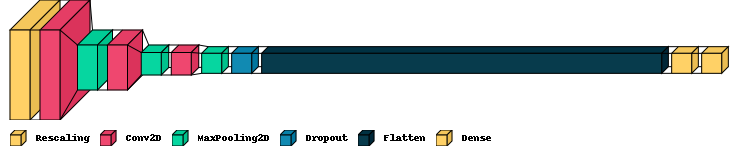

In [28]:
visualkeras.layered_view(model, legend=True, scale_xy=0.5)

### Train the model
The model was trained for 15 epochs since through testing, more epochs overfits the model

In [20]:
epochs = 15
history = model.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/15
65/65 [==============================] - 36s 549ms/step - loss: 0.6492 - accuracy: 0.6958 - val_loss: 0.4333 - val_accuracy: 0.7707
Epoch 2/15
65/65 [==============================] - 37s 568ms/step - loss: 0.3390 - accuracy: 0.8450 - val_loss: 0.2785 - val_accuracy: 0.8763
Epoch 3/15
65/65 [==============================] - 36s 553ms/step - loss: 0.2587 - accuracy: 0.8931 - val_loss: 0.2495 - val_accuracy: 0.8899
Epoch 4/15
65/65 [==============================] - 35s 543ms/step - loss: 0.2064 - accuracy: 0.9203 - val_loss: 0.2752 - val_accuracy: 0.8854
Epoch 5/15
65/65 [==============================] - 35s 543ms/step - loss: 0.1733 - accuracy: 0.9368 - val_loss: 0.3014 - val_accuracy: 0.8649
Epoch 6/15
65/65 [==============================] - 35s 543ms/step - loss: 0.1299 - accuracy: 0.9534 - val_loss: 0.4377 - val_accuracy: 0.8320
Epoch 7/15
65/65 [==============================] - 35s 535ms/step - loss: 0.1340 - accuracy: 0.9563 - val_loss: 0.2691 - val_accuracy: 0.8854

### Plot history
Visualize the training and testing history across epochs

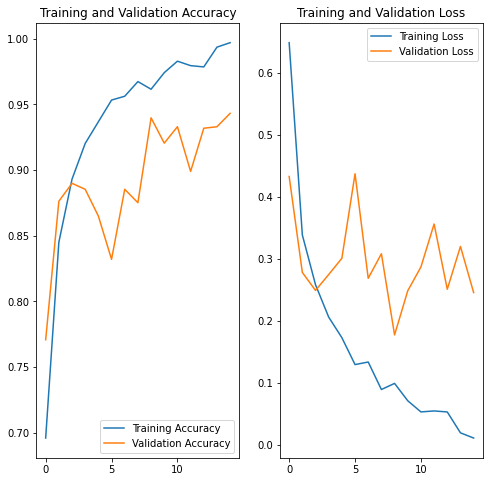

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Create confusion matrix
Visualize the correct and wrong predictions across classes

1/1 [==============================] - 0s 152ms/step
Prediction Accuracy: 94.32%


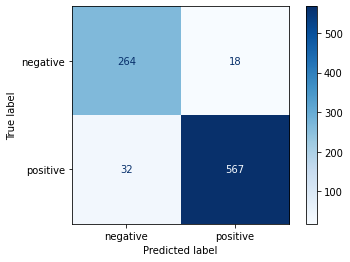

In [22]:
# Create the confusion matrix
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:
   # append true labels
   y_true.append(label_batch)
    
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

# create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# compute accuracy in confusion matrix
acc = sum([cm[i][i] for i in range(len(cm))]) / np.sum(np.concatenate(cm))
print("Prediction Accuracy: {0:.2f}%".format(acc * 100))

# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Save the model 
For future use so that it can be used without having to retrain

In [23]:
model.save('model.h5')

### Predict image
Download an image to test the model

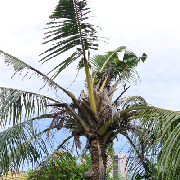

1/1 [==============================] - 0s 123ms/step
The tree is infected with a 95.64 percent confidence.


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
img_height = 180
img_width = 180
class_names = ["not infected", "infected"]

# Load saved model
model = keras.models.load_model('model.h5')

def test_img(url):
    # Get the image
    try:
        test_img_path = tf.keras.utils.get_file(origin=url)
        img = tf.keras.utils.load_img(test_img_path, target_size=(img_height, img_width))
    except Exception as e:
        print(e)
        return    
    
    # Display the image
    display(img)

    # Predict the image
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.relu(predictions[0])

    # Display results
    print(
        "The tree is {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 10 * np.max(score))
    )

    
# URL of the picture to test
test_url = "https://blogs.ifas.ufl.edu/pestalert/files/2015/09/Oryctes_rhinoceros01.jpg"
test_img(test_url)